# PUR-Check: Automatisierte Zellanalyse von Polyurethan-Hartschaumproben

### Initialisierung von Bibliotheken

In [1]:
# Standardbibliotheken
import os
import random
import numpy as np

# Drittanbieterbibliotheken
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import imagej
import scyjava as sj

# ImageJ initialisieren
# Hinweis: Die Initialisierung von ImageJ kann einige Zeit in Anspruch nehmen, insbesondere beim ersten Start, da alle notwendigen Komponenten geladen werden.
ij = imagej.init('sc.fiji:fiji')
print(f"ImageJ2 Version: {ij.getVersion()}")

ImageJ2 Version: 2.15.0/1.54f


### Bild Laden

In [2]:
# Zufälliges Bild aus dem Verzeichnis auswählen, falls es nicht leer ist
image_dir = r'D:\Studium\Master\Masterarbeit\dataset'
image_files = [x for x in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, x))]
if not image_files:
    raise FileNotFoundError(f"Keine Bilder im Verzeichnis gefunden: {image_dir}")
random_image = random.choice(image_files)
image_path = os.path.join(image_dir, random_image)

print('geladenes Bild:', image_path)

image = cv2.imread(image_path)

# Überprüfen, ob das Bild erfolgreich geladen wurde
if image is None:
    raise FileNotFoundError(f"Das Bild konnte nicht geladen werden: {image_path}")


geladenes Bild: D:\Studium\Master\Masterarbeit\dataset\212S1_T1_rec00000494.tif


### Bildvorbereitung - Ausschneiden

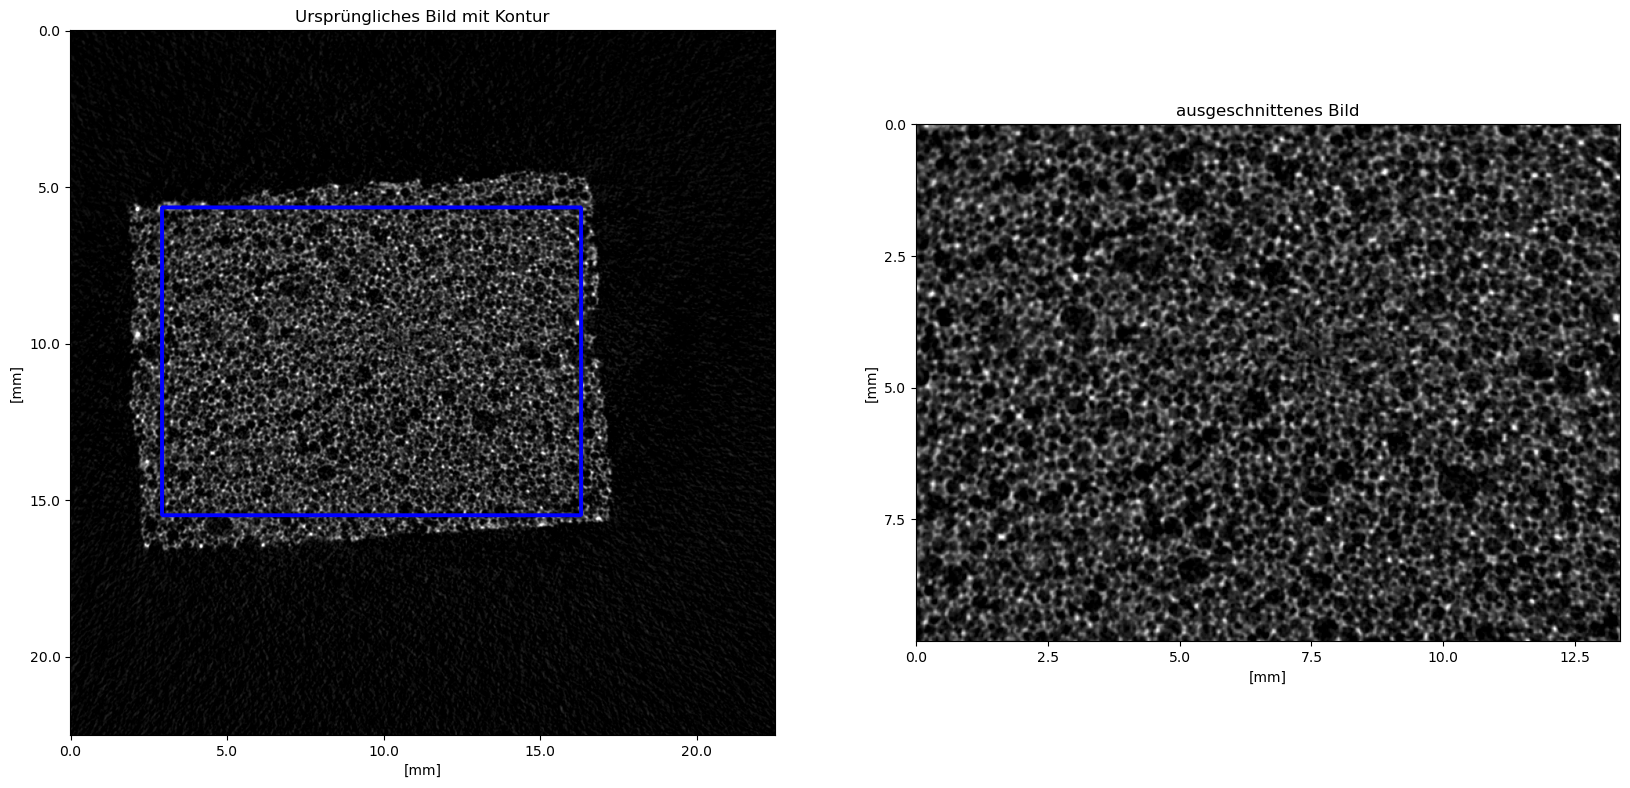

In [5]:
# Parameter für Verkleinerung
breiten_abzug = 90  # Anzahl der Pixel, um die die Breite der Kontur reduziert werden soll
hoehen_abzug = 100  # Anzahl der Pixel, um die die Höhe der Kontur reduziert werden soll

# Parameter für Umrechnung von Pixeln in Millimeter
pixel_to_mm = 0.025  

# Bild in RGB konvertieren (OpenCV lädt Bilder standardmäßig im BGR-Format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Graustufenbild erstellen und Kanten finden
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)  # Konvertiere das Bild in Graustufen
ret, thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)  # Binärschwellenwert anwenden

# Konturen finden
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Finde die äußeren Konturen

# Größte Kontur finden
if len(contours) != 0:
    c = max(contours, key=cv2.contourArea)  # Wähle die größte Kontur basierend auf der Fläche
    x, y, w, h = cv2.boundingRect(c)  # Berechne das umgebende Rechteck der größten Kontur

    # Neue Breite und Höhe um definierte Pixelanzahl verkleinern
    new_w = max(w - breiten_abzug, 1)  # Verhindere, dass die Breite auf 0 reduziert wird
    new_h = max(h - hoehen_abzug, 1)  # Verhindere, dass die Höhe auf 0 reduziert wird

    # Mittelpunkt der ursprünglichen Kontur berechnen
    center_x = x + w // 2  # Berechne den x-Koordinaten-Mittelpunkt der Kontur
    center_y = y + h // 2  # Berechne den y-Koordinaten-Mittelpunkt der Kontur

    # Neue obere linke Ecke berechnen, um den Ausschnitt zu zentrieren
    new_x = max(center_x - new_w // 2, 0)  # Berechne die neue obere linke x-Koordinate
    new_y = max(center_y - new_h // 2, 0)  # Berechne die neue obere linke y-Koordinate

    # Sicherstellen, dass die neuen Koordinaten innerhalb der Bildgrenzen liegen
    new_x = min(new_x, image_rgb.shape[1] - new_w)  # Überprüfe, ob die neue x-Koordinate im Bildbereich liegt
    new_y = min(new_y, image_rgb.shape[0] - new_h)  # Überprüfe, ob die neue y-Koordinate im Bildbereich liegt

    # Größte Kontur extrahieren
    img_crop = image_rgb[new_y:new_y+new_h, new_x:new_x+new_w]  # Extrahiere das Rechteck aus dem Bild

    # Rechteck auf dem ursprünglichen Bild zeichnen
    image_with_rect = image_rgb.copy()  # Erstelle eine Kopie des ursprünglichen Bildes
    cv2.rectangle(image_with_rect, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 0, 255), 3)  # Zeichne ein blaues Rechteck

    # Achsenbeschriftungen für das ursprüngliche Bild anpassen
    x_ticks = np.arange(0, image_rgb.shape[1], 200)  
    y_ticks = np.arange(0, image_rgb.shape[0], 200)
    x_labels = [f"{tick * pixel_to_mm:.1f}" for tick in x_ticks]  # Erstelle die Achsenbeschriftungen in mm
    y_labels = [f"{tick * pixel_to_mm:.1f}" for tick in y_ticks]

    # Achsenbeschriftungen für das ausgeschnittene Bild anpassen
    crop_x_ticks = np.arange(0, new_w, 100)  
    crop_y_ticks = np.arange(0, new_h, 100)
    crop_x_labels = [f"{tick * pixel_to_mm:.1f}" for tick in crop_x_ticks]
    crop_y_labels = [f"{tick * pixel_to_mm:.1f}" for tick in crop_y_ticks]

    # Bilder anzeigen
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    axs[0].imshow(image_with_rect)  # Zeige das ursprüngliche Bild mit gezeichneter Kontur
    axs[0].set_title("Ursprüngliches Bild mit Kontur")
    axs[0].set_xticks(x_ticks)
    axs[0].set_xticklabels(x_labels)
    axs[0].set_yticks(y_ticks)
    axs[0].set_yticklabels(y_labels)
    axs[0].set_xlabel("[mm]")
    axs[0].set_ylabel("[mm]")

    axs[1].imshow(img_crop)  # Zeige das ausgeschnittene Bild
    axs[1].set_title("ausgeschnittenes Bild")
    axs[1].set_xticks(crop_x_ticks)
    axs[1].set_xticklabels(crop_x_labels)
    axs[1].set_yticks(crop_y_ticks)
    axs[1].set_yticklabels(crop_y_labels)
    axs[1].set_xlabel("[mm]")
    axs[1].set_ylabel("[mm]")

    plt.show()  # Zeige die Plots
else:
    print("Keine Konturen gefunden.")  # Ausgabe, wenn keine Konturen gefunden wurden

## Vorverarbeitung der Bilder

#### Binäre Maske erstellen

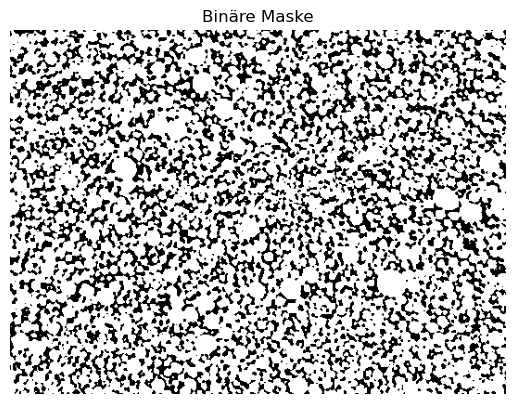

In [7]:
# Bild in Graustufen konvertieren
gray_image = cv2.cvtColor(img_crop, cv2.COLOR_RGB2GRAY)  # Konvertiere das ausgeschnittene Bild in Graustufen

# Bild binarisieren mit Otsu's Methode
_, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Binarisierung mit Otsu

# Binarisierte Maske invertieren, um das Objekt hervorzuheben
inverted_binary_mask = cv2.bitwise_not(binary_mask)  # Invertiere die Maske

# Bild anzeigen
plt.imshow(inverted_binary_mask, cmap='gray')  # Zeige die invertierte Maske an
plt.title('Binäre Maske')
plt.axis('off')  # Deaktiviere die Achsen
plt.show()


### Watershed

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the IJ class will not be fully functional.


Temporary image saved to C:\Users\Nour\Desktop\Image\tem\temp_watershed.tif


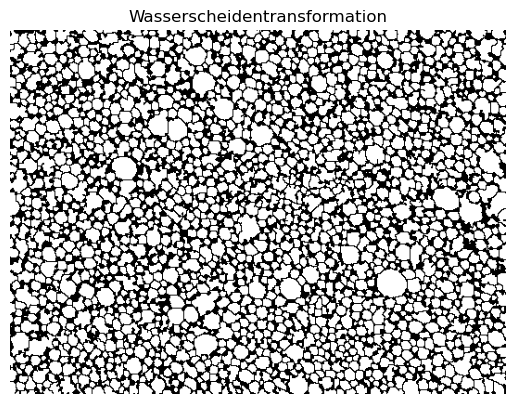

In [9]:
# Invertierte binäre Maske in ein ImageJ-Objekt konvertieren
imagej_object = ij.py.to_imageplus(inverted_binary_mask)  # Konvertiere die invertierte Maske in ein ImageJ-Objekt
imagej_object.updateAndDraw()  # Aktualisiere und zeichne das Bild

# Prozessor des Bildes erhalten
ip = imagej_object.getProcessor()  # Erhalte den Bildprozessor

# EDM importieren
EDM = sj.jimport('ij.plugin.filter.EDM')
edm = EDM()  # Erstellt eine EDM-Instanz (Euclidean Distance Map)

# Überprüfen, ob das Bild binär ist, und nur dann den Watershed-Algorithmus anwenden
if ip.isBinary():
    edm.setup("watershed", None)  # Bereite den Watershed-Algorithmus vor
    edm.run(ip)  # Führe den Watershed-Algorithmus aus

# Bild nach Watershed speichern
temp_output_path = r'C:\Users\Nour\Desktop\Image\tem\temp_watershed.tif'  # Temporärer Pfad zum Speichern des Bildes
ij.IJ().saveAs(imagej_object, "Tiff", temp_output_path)  # Speichere das Bild als TIFF-Datei
print(f"Temporary image saved to {temp_output_path}")

# Bild erneut öffnen
img_Watershed = cv2.imread(temp_output_path)  # Lade das gespeicherte Watershed-Bild

# Bild anzeigen
plt.imshow(img_Watershed, cmap='gray')  # Zeige das Watershed-Bild an
plt.title('Wasserscheidentransformation')
plt.axis('off')  # Deaktiviere die Achsen
plt.show()

### Konturenerkennung und Visualisierung der Segmentierungsergebnisse

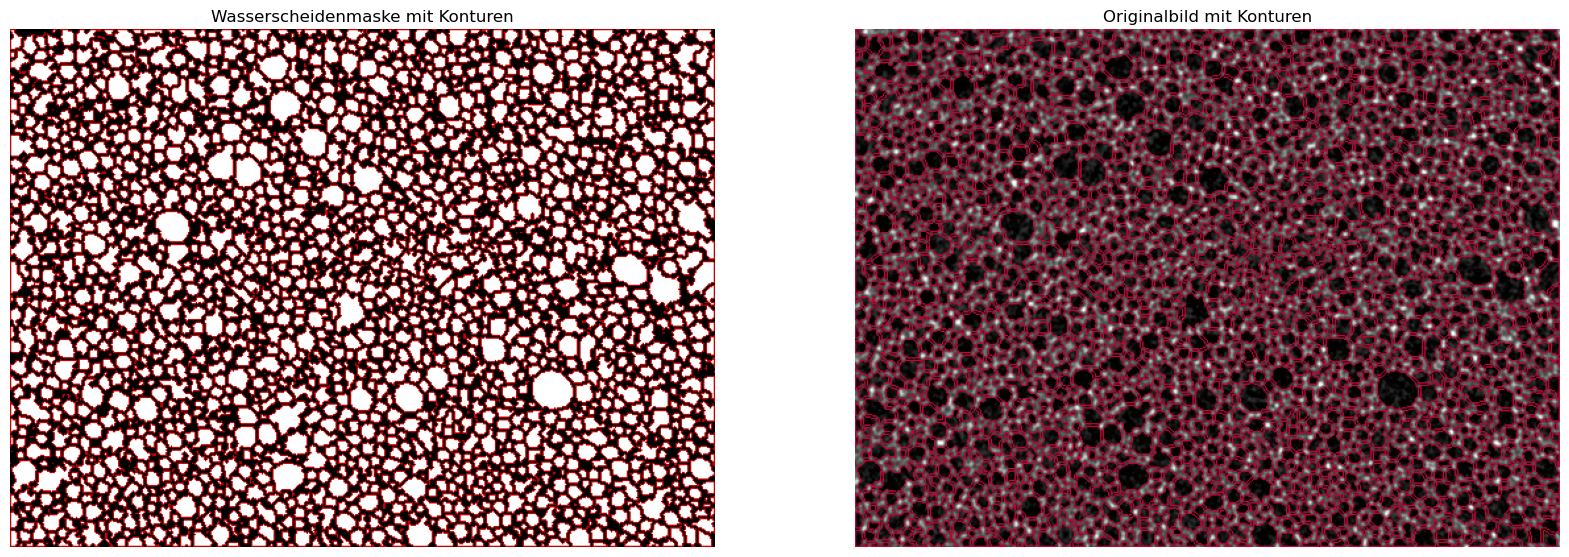

Watershed Image with Contours saved to C:\Users\NouraldinIdrees\Desktop\Image\tem\crop_watershed_contours.tif


In [11]:
# Bild erneut mit OpenCV laden, um Konturen zu zeichnen
img_Watershed_binary = cv2.imread(temp_output_path, cv2.IMREAD_UNCHANGED)  # Lade das Bild im ursprünglichen Format

# Überprüfen, ob das Watershed-Bild erfolgreich geladen wurde
if img_Watershed_binary is None:
    raise FileNotFoundError(f"Das Watershed-Bild konnte nicht geladen werden: {temp_output_path}")

# Konturen finden
contours, _ = cv2.findContours(img_Watershed_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Finde die äußeren Konturen

# Konturen auf dem Originalbild zeichnen
contour_img = img_crop.copy()  # Kopiere das ausgeschnittene Bild
cv2.drawContours(contour_img, contours, -1, (50, 0, 200), 1)  # Zeichne die Konturen auf dem Originalbild

# Konturen auf dem Watershed-Bild zeichnen
watershed_contour_img = cv2.cvtColor(img_Watershed_binary, cv2.COLOR_GRAY2BGR)  # Konvertiere das Watershed-Bild in BGR
cv2.drawContours(watershed_contour_img, contours, -1, (0, 0, 200), 1)  # Zeichne die Konturen auf dem Watershed-Bild

# Bilder anzeigen
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[1].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))  # Zeige das Originalbild mit Konturen
axes[1].set_title('Originalbild mit Konturen')
axes[1].axis('off')
axes[0].imshow(cv2.cvtColor(watershed_contour_img, cv2.COLOR_BGR2RGB))  # Zeige das Watershed-Bild mit Konturen
axes[0].set_title('Wasserscheidenmaske mit Konturen')
axes[0].axis('off')
plt.show()

# Endgültiges Bild mit Konturen speichern
contour_output_path = r'C:\Users\NouraldinIdrees\Desktop\Image\tem\crop_watershed_contours.tif'  # Pfad zum Speichern des endgültigen Bildes
cv2.imwrite(contour_output_path, contour_img)  # Speichere das Bild mit Konturen
print(f"Watershed Image with Contours saved to {contour_output_path}")


### Berechnung und Ausgabe der Zellmetriken

In [13]:
# Definiere den Umrechnungsfaktor von Pixel in mm² als Konstante
PIXEL_TO_MM2 = 0.025 ** 2

# Flächen der Zellen berechnen
cell_areas_px = [cv2.contourArea(cnt) for cnt in contours]  # Berechne die Fläche jeder Kontur in Pixeln
cell_areas_mm2 = [area * PIXEL_TO_MM2 for area in cell_areas_px]  # Umrechnung von Pixel in mm²

# Gesamtzellenfläche berechnen
total_cell_area_mm2 = sum(cell_areas_mm2)
# Mittlere Zellenfläche berechnen
average_cell_area_mm2 = total_cell_area_mm2 / len(cell_areas_mm2) if cell_areas_mm2 else 0
# Größte Zellenfläche finden
largest_cell_area_mm2 = max(cell_areas_mm2) if cell_areas_mm2 else 0
# Durchschnittlichen Zelldurchmesser berechnen (aus der mittleren Zellenfläche)
average_cell_diameter_mm = np.sqrt(4 * average_cell_area_mm2 / np.pi) if cell_areas_mm2 else 0

# Durchmesser der Zellen berechnen
cell_diameters_mm = [np.sqrt(4 * area / np.pi) for area in cell_areas_mm2]  # Berechne den Durchmesser jeder Zelle
mean_cell_diameter_mm = np.mean(cell_diameters_mm) if cell_areas_mm2 else 0  # Mittlerer Zelldurchmesser
max_cell_diameter_mm = np.max(cell_diameters_mm) if cell_areas_mm2 else 0  # Größter Zelldurchmesser

# Anforderungen nach EN 253 überprüfen
en253_requirement = 0.1 <= mean_cell_diameter_mm <= 0.5  # Prüfen, ob der mittlere Zelldurchmesser den Anforderungen entspricht

# Gesamtfläche des Bildes berechnen
total_area_px = watershed_contour_img.shape[0] * watershed_contour_img.shape[1]  # Berechne die Gesamtfläche in Pixeln
total_area_mm2 = total_area_px * PIXEL_TO_MM2  # Umrechnung von Pixel in mm²

# Fläche ohne Zellen berechnen
non_cell_area_mm2 = total_area_mm2 - total_cell_area_mm2  # Berechne die Fläche ohne Zellen

# Verhältnis der Zellenfläche zur Gesamtfläche berechnen
cell_area_ratio = total_cell_area_mm2 / total_area_mm2  # Verhältnis der Zellenfläche zur Gesamtfläche

# Anzahl der Zellen berechnen
num_cells = len(contours)  # Anzahl der gefundenen Zellen

# Ergebnisse ausgeben
print('geladenes Bild:', image_path)
print(f"Gesamtbildfläche: {total_area_mm2:.2f} mm²")
print(f"Gesamtzellenfläche: {total_cell_area_mm2:.2f} mm²")
print(f"Fläche ohne Zellen: {non_cell_area_mm2:.2f} mm²")
print(f"Mittlere Zellenfläche: {average_cell_area_mm2:.4f} mm²")
print(f"Größte Zellenfläche: {largest_cell_area_mm2:.4f} mm²")
print(f"Anzahl der Zellen: {num_cells}")
print(f"Verhältnis der Zellenfläche zur Gesamtbildfläche: {cell_area_ratio:.2%}")
print(f"Mittlerer Zelldurchmesser: {mean_cell_diameter_mm:.3f} mm")
print(f"Durchmesser der größten Zelle: {max_cell_diameter_mm:.3f} mm")
if en253_requirement:
    print("Der mittlere Zelldurchmesser erfüllt die Anforderungen nach EN 253.")
else:
    print("Der mittlere Zelldurchmesser erfüllt NICHT die Anforderungen nach EN 253.")

geladenes Bild: D:\Studium\Master\Masterarbeit\dataset\212S1_T1_rec00000494.tif
Gesamtbildfläche: 131.41 mm²
Gesamtzellenfläche: 66.19 mm²
Fläche ohne Zellen: 65.22 mm²
Mittlere Zellenfläche: 0.0346 mm²
Größte Zellenfläche: 0.4475 mm²
Anzahl der Zellen: 1914
Verhältnis der Zellenfläche zur Gesamtbildfläche: 50.37%
Mittlerer Zelldurchmesser: 0.188 mm
Durchmesser der größten Zelle: 0.755 mm
Der mittlere Zelldurchmesser erfüllt die Anforderungen nach EN 253.


### Visualisierung der Zellflächen und Zelldurchmesser durch Histogramme

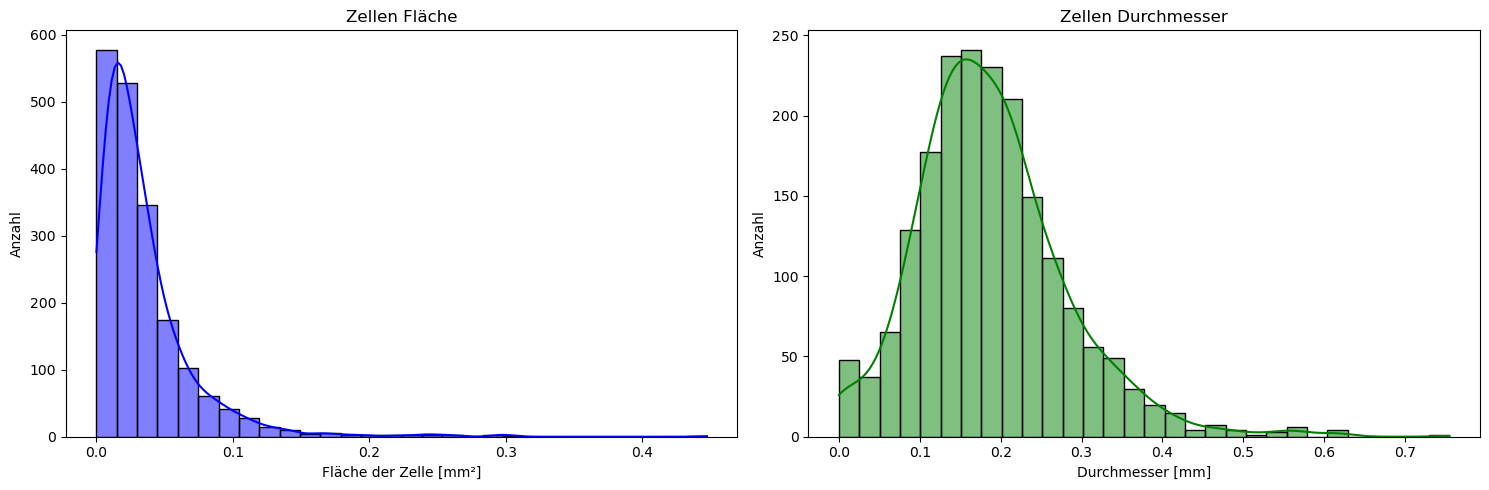

In [15]:
# Histogramme erstellen
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramm Plot für Zellflächen
num_bins_area = min(30, len(cell_areas_mm2) // 10 + 1)  
sns.histplot(cell_areas_mm2, bins=num_bins_area, kde=True, color='blue', edgecolor='black', ax=axes[0])  # Plot für Zellflächen
axes[0].set_title('Zellen Fläche')
axes[0].set_xlabel('Fläche der Zelle [mm²]')
axes[0].set_ylabel('Anzahl')

# Histogramm Plot für Zelldurchmesser
num_bins_diameter = min(30, len(cell_diameters_mm) // 10 + 1)  
sns.histplot(cell_diameters_mm, bins=num_bins_diameter, kde=True, color='green', edgecolor='black', ax=axes[1])  # Plot für Zelldurchmesser
axes[1].set_title('Zellen Durchmesser')
axes[1].set_xlabel('Durchmesser [mm]')
axes[1].set_ylabel('Anzahl')

plt.tight_layout()
plt.show()

### Auswertung der Zellkonturen basierend auf einer definierten Linie nach DIN EN 253

Anzahl der gefilterten Zellen: 40
Durchschnittliche Fläche der gefilterten Zellen: 0.0528 mm²
Größte gefilterte Zellenfläche: 0.2603 mm²
Durchschnittlicher Durchmesser der gefilterten Zellen: 0.23 mm
Durchmesser der größten gefilterten Zelle: 0.58 mm
Der Durchmesser der mittleren gefilterten Zelle erfüllt die Anforderungen nach EN 253.


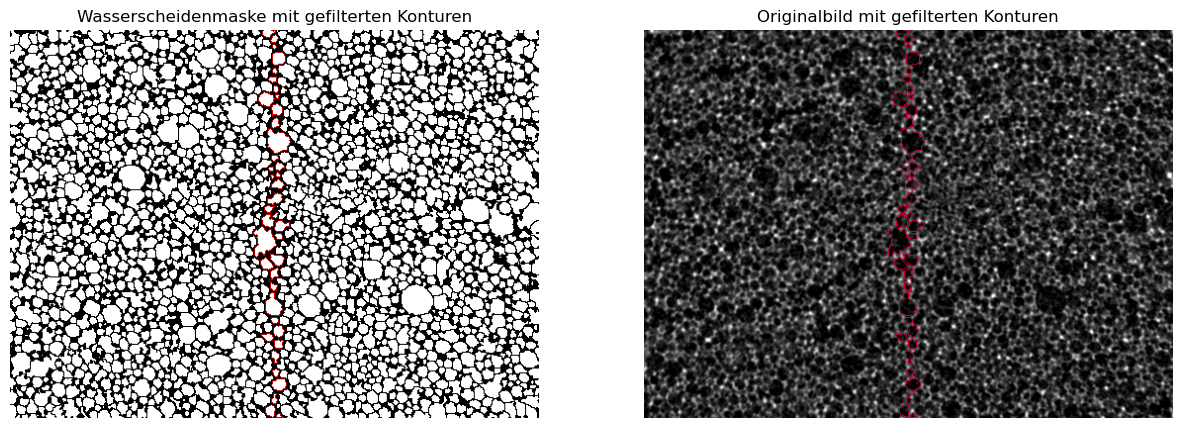

In [17]:
# Definiere den Umrechnungsfaktor von mm in Pixel als Konstante
MM_TO_PIXEL = 0.025

# Funktion zur Umrechnung der Zellfläche in mm² definieren
def calculate_cell_areas_mm2(cell_areas_px, pixel_to_mm2):
    return [area * pixel_to_mm2 for area in cell_areas_px]

# Watershed-Maske laden
watershed_mask = cv2.imread(temp_output_path, cv2.IMREAD_GRAYSCALE)  # Lade die Watershed-Maske in Graustufen

# Linie definieren
line_length = 10  # Länge der Linie in mm
line_pixels = int(line_length / MM_TO_PIXEL)  # Umrechnung von mm in Pixel
line_start_x = watershed_mask.shape[1] // 2  # Startpunkt der Linie in der Mitte des Bildes (x-Richtung)
line_start_y = watershed_mask.shape[0] // 2  # Startpunkt der Linie in der Mitte des Bildes (y-Richtung)
line_end_x = line_start_x  # Endpunkt der Linie hat denselben x-Wert wie der Startpunkt
line_end_y = line_start_y + line_pixels  # Endpunkt der Linie in der y-Richtung

# Höhe des Bildes prüfen
if watershed_mask is None:
    raise FileNotFoundError(f"Die Watershed-Maske konnte nicht geladen werden: {temp_output_path}")

if watershed_mask.shape[0] < line_pixels:
    line_start_y = 0
    line_end_y = watershed_mask.shape[0]  # Setze die Linie auf die gesamte Höhe, falls das Bild kleiner ist als die Linienlänge
else:
    line_start_y = watershed_mask.shape[0] // 2 - line_pixels // 2  # Zentriere die Linie in der Bildmitte
    line_end_y = line_start_y + line_pixels

# Konturen filtern 
filtered_contours = [
    contour for contour in contours
    if any(line_start_y <= point[0][1] <= line_end_y and line_start_x - line_pixels // 400 <= point[0][0] <= line_start_x + line_pixels // 400 for point in contour)
]

# Konvertiere das Watershed-Bild in BGR (nur einmal)
filtered_watershed_contour_img = cv2.cvtColor(watershed_mask, cv2.COLOR_GRAY2BGR)  # Konvertiere das Watershed-Bild von Graustufen zu BGR

# Gefilterte Konturen auf dem Watershed-Bild zeichnen
cv2.drawContours(filtered_watershed_contour_img, filtered_contours, -1, (0, 0, 200), 1)  # Zeichne die gefilterten Konturen auf dem Watershed-Bild

# Gefilterte Konturen auf dem Originalbild zeichnen
filtered_contour_img = img_crop.copy()  # Kopiere das ausgeschnittene Bild
cv2.drawContours(filtered_contour_img, filtered_contours, -1, (50, 0, 200), 1)  # Zeichne die gefilterten Konturen auf dem Originalbild

# Flächen der gefilterten Zellen berechnen
filtered_cell_areas_px = [cv2.contourArea(cnt) for cnt in filtered_contours]  # Berechne die Fläche jeder gefilterten Kontur in Pixeln
filtered_cell_areas_mm2 = calculate_cell_areas_mm2(filtered_cell_areas_px, MM_TO_PIXEL ** 2)  # Umrechnung der Flächen von Pixel in mm²

# Gesamtfläche der gefilterten Zellen berechnen
total_filtered_cell_area_mm2 = sum(filtered_cell_areas_mm2)  # Summe der Flächen aller gefilterten Zellen

# Mittlere Fläche der gefilterten Zellen berechnen
average_filtered_cell_area_mm2 = total_filtered_cell_area_mm2 / len(filtered_cell_areas_mm2) if filtered_cell_areas_mm2 else 0  

# Größte Fläche der gefilterten Zellen finden
largest_filtered_cell_area_mm2 = max(filtered_cell_areas_mm2) if filtered_cell_areas_mm2 else 0  # Größte gefilterte Zellenfläche, falls vorhanden

# Durchmesser der gefilterten Zellen berechnen
filtered_cell_diameters_mm = [np.sqrt(4 * area / np.pi) for area in filtered_cell_areas_mm2]  # Berechne den Durchmesser jeder gefilterten Zelle
mean_filtered_cell_diameter_mm = np.mean(filtered_cell_diameters_mm) if filtered_cell_diameters_mm else 0  # Mittlerer Durchmesser der gefilterten Zellen
max_filtered_cell_diameter_mm = np.max(filtered_cell_diameters_mm) if filtered_cell_diameters_mm else 0  # Größter Durchmesser der gefilterten Zellen

# Anforderungen nach EN 253 überprüfen
en253_requirement = 0.1 <= mean_filtered_cell_diameter_mm <= 0.5  # Prüfen, ob der mittlere gefilterte Zelldurchmesser den Anforderungen entspricht

# Ergebnisse ausgeben
print(f"Anzahl der gefilterten Zellen: {len(filtered_contours)}")
print(f"Durchschnittliche Fläche der gefilterten Zellen: {average_filtered_cell_area_mm2:.4f} mm²")
print(f"Größte gefilterte Zellenfläche: {largest_filtered_cell_area_mm2:.4f} mm²")
print(f"Durchschnittlicher Durchmesser der gefilterten Zellen: {mean_filtered_cell_diameter_mm:.2f} mm")
print(f"Durchmesser der größten gefilterten Zelle: {max_filtered_cell_diameter_mm:.2f} mm")
if en253_requirement:
    print("Der Durchmesser der mittleren gefilterten Zelle erfüllt die Anforderungen nach EN 253.")
else:
    print("Der Durchmesser der mittleren gefilterten Zelle erfüllt NICHT die Anforderungen nach EN 253.")

# Bilder anzeigen
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[1].imshow(cv2.cvtColor(filtered_contour_img, cv2.COLOR_BGR2RGB))  # Zeige das Originalbild mit gefilterten Konturen
axes[1].set_title('Originalbild mit gefilterten Konturen')
axes[1].axis('off')
axes[0].imshow(cv2.cvtColor(filtered_watershed_contour_img, cv2.COLOR_BGR2RGB))  # Zeige das Watershed-Bild mit gefilterten Konturen
axes[0].set_title('Wasserscheidenmaske mit gefilterten Konturen')
axes[0].axis('off')
plt.show()

## Automatisierte Analyse der Zellwanddicke durch Distanztransformation und Visualisierung

### Berechnung und Visualisierung der Wanddicke der Zellwände

In [19]:
# Invertiere die Binärmaske, um die Hintergrund- und Vordergrundpixel umzudrehen
mask=cv2.bitwise_not(img_Watershed_binary)

# Berechne die Distanztransformation der invertierten Maske
# cv2.DIST_L2 verwendet die euklidische Distanz, und die Blockgröße von 3 wird verwendet, um die Genauigkeit zu erhöhen
dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 3)

# Definiere den Umrechnungsfaktor von Pixel in mm als Konstante
PIXEL_TO_MM = 0.025

# Wanddicken berechnen
# Extrahiere die Wanddickenwerte aus der Distanztransformation, wo die Originalmaske null ist (d.h. Wände)
wall_thicknesses = dist_transform[img_Watershed_binary == 0]
if len(wall_thicknesses) == 0:
    raise ValueError("Keine Wanddickenwerte gefunden. Überprüfen Sie die Maske auf Fehler.")

# Berechnung der mittleren Wanddicke     
mean_wall_thickness = np.mean(wall_thicknesses) * PIXEL_TO_MM  # Umrechnung von Pixel in mm

# Berechnung der maximalen Wanddicke
max_wall_thickness = np.max(wall_thicknesses) * PIXEL_TO_MM  # Umrechnung von Pixel in mm

# Ausgabe der berechneten Werte
print(f"Mittlere Wanddicke: {mean_wall_thickness:.4f} mm")
print(f"Maximale Wanddicke: {max_wall_thickness:.4f} mm")


Mittlere Wanddicke: 0.0317 mm
Maximale Wanddicke: 0.1401 mm


### Visualisierung der Zellwände mit farbcodierter Distanztransformation

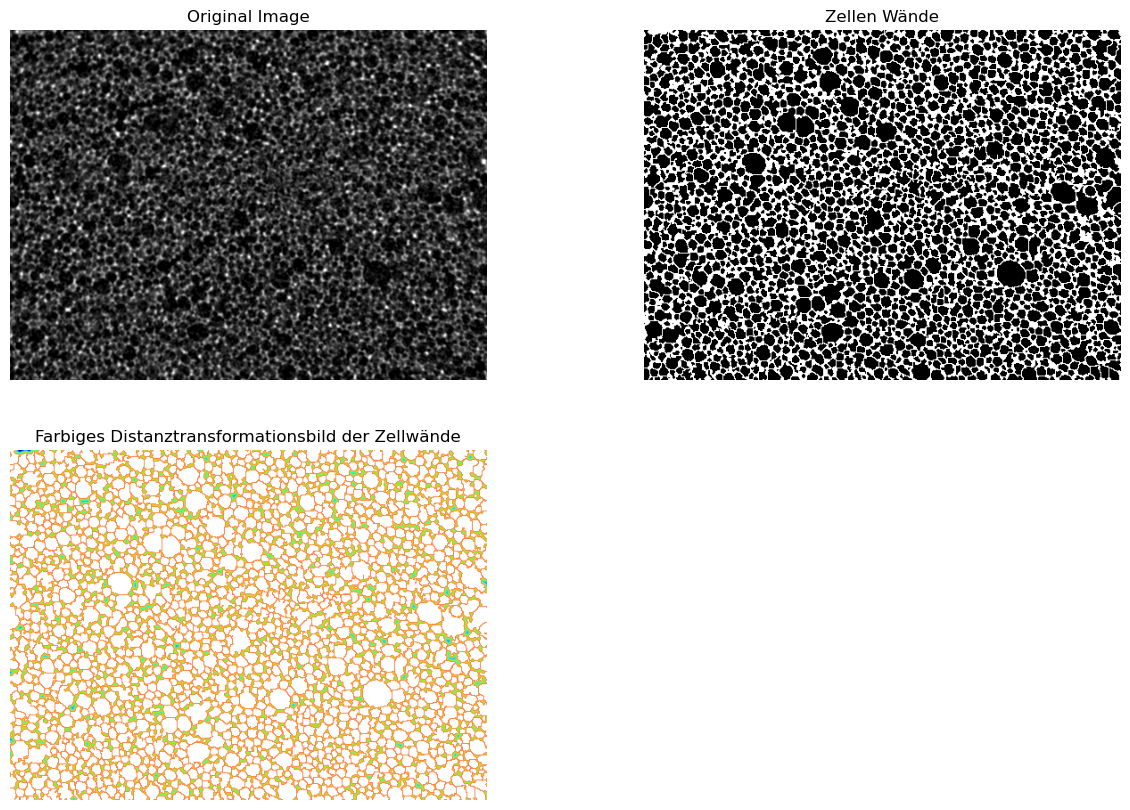

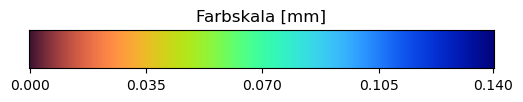

In [21]:
# Distanztransformation normalisieren und in Farben anzeigen
# Normalisiere die Distanztransformation, um Werte zwischen 0 und 255 zu erhalten
dist_transform_normalized = cv2.normalize(dist_transform, None, 0, 255, cv2.NORM_MINMAX)
dist_transform_uint8 = dist_transform_normalized.astype(np.uint8)

# Wende eine Farbkarte auf die normalisierte Distanztransformation an, um die Visualisierung zu verbessern
dist_transform_colored = cv2.applyColorMap(dist_transform_uint8, cv2.COLORMAP_TURBO)

# Setze die Hintergrundbereiche (Zellen) auf Weiß
# Dadurch werden die Zellen besser von den Wandbereichen unterschieden
dist_transform_colored[img_Watershed_binary == 255] = [255, 255, 255]

# Ergebnisse anzeigen
plt.figure(figsize=(15, 10))  # Größeres Bild für 2x2 Raster

# Original Image
plt.subplot(2, 2, 1)  # 2 Zeilen, 2 Spalten, erster Plot
plt.title('Original Image')
plt.imshow(img_crop, cmap='gray')
plt.axis('off')

# Zellen Wände
plt.subplot(2, 2, 2)  # 2 Zeilen, 2 Spalten, zweiter Plot
plt.title('Zellen Wände')
plt.imshow(mask, cmap='gray')
plt.axis('off')

# Farbiges Distanztransformationsbild der Zellwände
plt.subplot(2, 2, 3)  # 2 Zeilen, 2 Spalten, dritter Plot
plt.title('Farbiges Distanztransformationsbild der Zellwände')
plt.imshow(dist_transform_colored)
plt.axis('off')

# Farbskala anzeigen, um die Wanddicke in mm darzustellen
plt.figure(figsize=(6, 0.5))
plt.title('Farbskala [mm]')
colorbar_img = np.linspace(0, 255, 256).astype(np.uint8)
colorbar_img = np.tile(colorbar_img, (1, 1))
colorbar_img_colored = cv2.applyColorMap(colorbar_img, cv2.COLORMAP_TURBO)
plt.imshow(colorbar_img_colored, aspect='auto')
plt.yticks([])
plt.xticks([0, 64, 128, 192, 255], [f'{v:.3f}' for v in np.linspace(0, max_wall_thickness, 5)])
plt.show()

### Statistische Analyse der Wanddicken mit Weibull-Verteilung

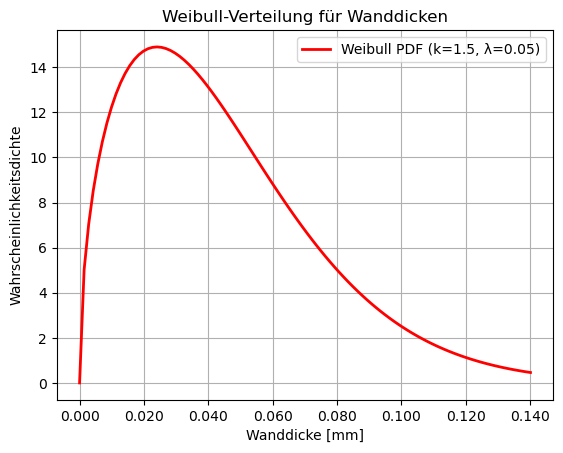

In [23]:
from scipy.stats import weibull_min

# Wanddicken in mm
wall_thicknesses_mm = [wt * PIXEL_TO_MM for wt in wall_thicknesses]

# Weibull-Parameter
k = 1.5  # Formparameter
lambda_ = 0.05  # Skalenparameter

# Weibull-Density Plot mit benutzerdefinierten Parametern
x = np.linspace(0, max_wall_thickness, 100)
plt.plot(x, weibull_min.pdf(x, k, scale=lambda_), 'r-', lw=2, label=f'Weibull PDF (k={k}, λ={lambda_})')

plt.title('Weibull-Verteilung für Wanddicken')
plt.xlabel('Wanddicke [mm]')
plt.ylabel('Wahrscheinlichkeitsdichte')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.3f}".format(x)))
plt.legend()
plt.grid(True)
plt.show()